In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

In [2]:
df_course = pd.read_csv('df_course.csv')
df_skill = pd.read_csv('df_skill.csv')
df_job = pd.read_csv('df_job.csv')

In [3]:
combined_df = pd.read_csv('combined_df.csv')
combined_df.set_index('id', inplace=True)
combined_df

,21491.BIO.01.002,11202.BIO.01.007,13291.BIO.01.006,81000.BIO.01.004,21491.BIO.01.004,31171.BIO.01.002,31171.BIO.01.001,11202.BIO.01.004,21411.BIO.01.001,13211.BIO.02.003,...,WPH-QUA-5021-1.1,WPH-TEM-3017-1.1,WPH-TEM-3011-1.1,WPH-WSH-2079-1.1,WPH-WSH-2080-1.1,WPH-WSH-2081-1.1,WPH-WSH-2082-1.1,WPH-WSH-2083-1.1,WPH-WSH-1084-1.1,WPH-WSH-2085-1.1
id,,,,,,,,,,,,,,,,,,,,,
Microsoft Excel 2013 Pivot Table Proficiency,0.194556,0.226599,0.236577,0.168272,0.192360,0.144812,0.130970,0.158558,0.165296,0.213930,...,0.122777,0.069214,0.190008,0.116900,0.076010,0.105481,0.106867,0.118039,0.027858,0.070382
Air-Conditioning - Basic Maintenance for Home Split Unit,0.463462,0.332766,0.303968,0.389904,0.424683,0.437648,0.438182,0.284278,0.360169,0.291673,...,0.259642,0.091802,0.191264,0.385306,0.337609,0.391550,0.311932,0.382708,0.285145,0.258679
Certificate in Athlete Life Coaching,0.106445,0.174246,0.275214,0.099131,0.116125,0.044984,0.086047,0.161490,0.134872,0.188044,...,0.059935,0.002637,0.077771,0.131388,0.061322,0.087407,0.075480,0.124139,0.197492,0.059241
Certificate Course in 2nd Grade Computer Aided Drafting (For Steam Engineers),0.276073,0.224004,0.216180,0.233198,0.287711,0.272979,0.232479,0.247889,0.331035,0.267415,...,0.070283,0.038585,0.183365,0.102640,0.134648,0.139846,0.085284,0.074175,0.085680,0.141346
Certificate Course in 2nd Grade Mechanics II (For Steam Engineers),0.353463,0.230359,0.182889,0.209073,0.311216,0.296133,0.336991,0.126780,0.269016,0.162624,...,0.086786,0.075635,0.160272,0.114358,0.129221,0.213246,0.128900,0.152158,0.085555,0.167762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"""Think Out Of The Box"" (Synchronous e-Learning)",0.210901,0.333999,0.341544,0.235051,0.242131,0.212703,0.209905,0.356412,0.342725,0.380354,...,0.225401,0.170847,0.284060,0.267983,0.255718,0.290535,0.238836,0.306993,0.271321,0.217270
EC-Council Certified Ethical Hacker (Synchronous e-learning),0.250889,0.224836,0.248210,0.209263,0.248646,0.223167,0.189617,0.192802,0.185328,0.217207,...,0.214030,0.266393,0.194591,0.195491,0.154658,0.164491,0.191215,0.189100,0.282373,0.232613
Family Mediation Certification Programme (Module 1) Family Law,0.142952,0.163439,0.215198,0.166790,0.143191,0.112655,0.142827,0.186035,0.174769,0.173875,...,0.080103,0.020701,0.013030,0.179699,0.179039,0.161446,0.137110,0.167422,0.209882,0.140137


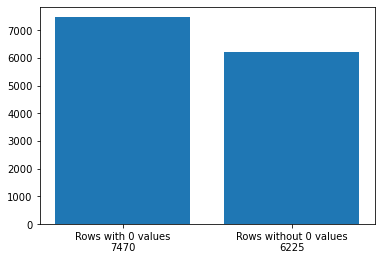

In [4]:
course_jobskill_matrix = combined_df.values
course_jobskill_matrix.shape

threshold = 0.6

filtered_matrix = np.where(course_jobskill_matrix < threshold, 0, course_jobskill_matrix)

# Replace non-zero values with 1
filtered_matrix[filtered_matrix != 0] = 1

# Count rows with at least one "1"
row_counts = np.sum(filtered_matrix, axis=1) > 0
rows_with_ones = np.sum(row_counts)

# Calculate the number of rows with 0 and 1
rows_with_zeros = filtered_matrix.shape[0] - rows_with_ones

# Create a bar chart to visualize the comparison
labels = ['Rows with 0 values\n{}'.format(rows_with_zeros), 'Rows without 0 values\n{}'.format(rows_with_ones)]
values = [rows_with_zeros, rows_with_ones]

plt.bar(labels, values)
plt.show()

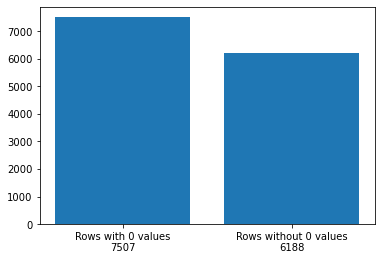

In [5]:
# Transpose the matrix
transposed_matrix = np.transpose(filtered_matrix)

# Perform matrix multiplication to project onto Set A
monopartite_matrix = np.dot(filtered_matrix, transposed_matrix)
monopartite_matrix[np.diag_indices_from(monopartite_matrix)] = 0

# Count rows with at least one "1"
row_counts = np.sum(monopartite_matrix, axis=1) > 0
rows_with_ones = np.sum(row_counts)

# Calculate the number of rows with 0 and 1
rows_with_zeros = monopartite_matrix.shape[0] - rows_with_ones

# Create a bar chart to visualize the comparison
labels = ['Rows with 0 values\n{}'.format(rows_with_zeros), 'Rows without 0 values\n{}'.format(rows_with_ones)]
values = [rows_with_zeros, rows_with_ones]

plt.bar(labels, values)
plt.show()

In [6]:
#Construct Course network using monopartite_matrix
G = nx.Graph()
n = monopartite_matrix.shape[0]

for i in range(n):
    for j in range(i + 1, n):
        weight = float(monopartite_matrix[i][j])  
        if weight > 0:
          G.add_edge(i, j, weight=weight)

In [7]:
#add course name attributes to each node
node_names = combined_df.index
node_indices = np.arange(filtered_matrix.shape[0])
node_index_to_name = {index: name for index, name in zip(node_indices, node_names)}
for node in G.nodes:
    G.nodes[node]['name'] = node_index_to_name[node]

In [20]:
#extract id(course name) and label from course dataframe
df_course_columns = ['id', 'course_label']
#by matching with the names(ids) of each node, assign labels to each node
for node in G.nodes():
    node_name = G.nodes[node]['name']
    corresponding_row = df_course[df_course['id'] == node_name]
    if not corresponding_row.empty:
        label_value = corresponding_row.iloc[0][df_course_columns[1]]
        G.nodes[node]['label'] = label_value
    else:
        G.nodes[node]['label'] = 'Unknown'

In [9]:
#Calculate course_coverage for each node and assign
row_sums = np.sum(filtered_matrix, axis=1)
course_index = combined_df.index
course_coverage_df = pd.DataFrame(data={'row_sum': row_sums}, index=course_index)

# Iterate through the nodes in the graph and update the 'row_sum' attribute
for node in G.nodes():
    node_name = G.nodes[node]['name']
    if node_name in course_coverage_df.index:
        G.nodes[node]['course_coverage'] = course_coverage_df.loc[node_name, 'row_sum']

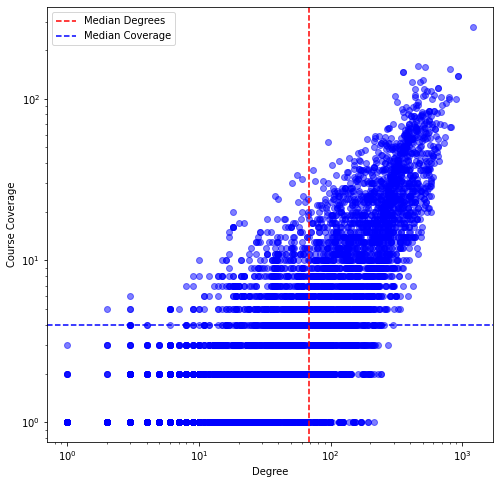

In [12]:
degrees = list(dict(G.degree()).values())
course_coverage = [G.nodes[node]['course_coverage'] for node in G.nodes() if 'course_coverage' in G.nodes[node]]

#To compare Course Coverage and Degree Centrality, draw a scatter plot
plt.figure(figsize=(8, 8))  
plt.scatter(degrees, course_coverage, alpha=0.5, color='blue')

plt.xscale('log')
plt.yscale('log')

plt.xlabel("Degree")
plt.ylabel("Course Coverage")

median_degree = np.median(degrees)
median_coverage = np.median(course_coverage)

# Draw axlines for median values
plt.axvline(median_degree, color='red', linestyle='--', label='Median Degrees')
plt.axhline(median_coverage, color='blue', linestyle='--', label='Median Coverage')

plt.legend()
plt.show()

In [13]:
#to calcualte course specificity, start with making a bipartite network of course-job/skill
B = nx.Graph()

course_names = combined_df.index
skill_names = combined_df.columns

B.add_nodes_from(course_names, bipartite=0) 
B.add_nodes_from(skill_names, bipartite=1)   

for i in range(len(course_names)):
    course_name = course_names[i]
    for j in range(len(skill_names)):
        value = filtered_matrix[i, j]
        if value == 1:
            skill_name = skill_names[j]
            B.add_edge(course_name, skill_name)

In [14]:
#assign labels to each node in B
labels_course = {node: row['course_label'] for node, row in df_course.set_index('id').iterrows()}
labels_skill = {node: row['skill_label'] for node, row in df_skill.set_index('id').iterrows()}
labels_job = {node: row['job_label'] for node, row in df_job.set_index('id').iterrows()}

for node in B.nodes():
    if B.nodes[node]['bipartite'] == 0:
        B.nodes[node]['label'] = labels_course.get(node, None)
    elif B.nodes[node]['bipartite'] == 1:
        B.nodes[node]['label'] = labels_skill.get(node, None) or labels_job.get(node, None)

In [15]:
# Calculate kc0 and kpo values from the edge_list
edge_list = nx.to_pandas_edgelist(B)
kc0 = edge_list.groupby('source')['target'].count().reset_index()
kp0 = edge_list.groupby('target')['source'].count().reset_index()

#Save kc0 in source nodes as 'kc0' attributes
for node, kc0_value in zip(kc0['source'], kc0['target']):
    if node in B.nodes:
        B.nodes[node]['kc0'] = kc0_value

#Save kp0 in target nodes as 'kp0' attributes
for node, kp0_value in zip(kp0['target'], kp0['source']):
    if node in B.nodes:
        B.nodes[node]['kp0'] = kp0_value

In [16]:
# Loop for calculating kc1 to kc2
for iteration in range(1, 3):  # Assuming you want to calculate up to kc2

    # Calculate kc_i for each source node
    for source_node in B.nodes:
        neighbors = list(B.neighbors(source_node))

        # Sum kp(i-1) attributes of neighbors that have 'kp(i-1)' values
        kp_sum = sum(B.nodes[neighbor]['kp{}'.format(iteration-1)] for neighbor in neighbors
                     if 'kp{}'.format(iteration-1) in B.nodes[neighbor])

        # Divide the sum of kp0 attribute by inverse of kc0 of the source node
        if 'kc0' in B.nodes[source_node]:
            kc0_value = B.nodes[source_node]['kc0']
            B.nodes[source_node]['kc{}'.format(iteration)] = kp_sum / kc0_value

    # Calculate kp_i for each target node
    for target_node in B.nodes:
        source_node_neighbors = list(B.neighbors(target_node))

        # Sum kc(i) attributes of source node neighbors
        kc_sum = sum(B.nodes[source]['kc{}'.format(iteration-1)] for source in source_node_neighbors
                    if 'kc{}'.format(iteration-1) in B.nodes[source])

        # Divide the sum of kc(i) attribute by kpo of the target node
        if 'kp0' in B.nodes[target_node]:
            kp0_value = B.nodes[target_node]['kp0']
            B.nodes[target_node]['kp{}'.format(iteration)] = kc_sum / kp0_value

In [17]:
# Extract data from source nodes
source_data = {'Node': []}
for i in range(3):  # Assuming you want kc0 to kc10
    source_data[f'kc{i}'] = []

for node in B.nodes:
    source_data['Node'].append(node)
    for i in range(3):
        attribute_key = f'kc{i}'
        source_data[attribute_key].append(B.nodes[node].get(attribute_key, np.nan))

# Create a dataframe from the extracted data
kc_df = pd.DataFrame(source_data)
kc_df = kc_df.dropna()
kc_df

,Node,kc0,kc1,kc2
2,Certificate in Athlete Life Coaching,1.0,29.000000,4.586207
3,Certificate Course in 2nd Grade Computer Aided...,8.0,30.875000,7.374637
7,Certificate Course in 2nd Grade Engineering Ma...,3.0,4.333333,2.133333
8,Certificate Course in 1st Grade Engineering Kn...,1.0,2.000000,33.000000
9,Certificate Course in 1st Grade Engineering Ma...,2.0,5.500000,2.200000
...,...,...,...,...
13689,Audit Management I,10.0,12.500000,18.679067
13690,"""Think Out Of The Box"" (Synchronous e-Learning)",6.0,44.500000,25.000518
13692,Family Mediation Certification Programme (Modu...,1.0,13.000000,6.000000
13693,Family Mediation Certification Programme (Modu...,1.0,13.000000,6.000000


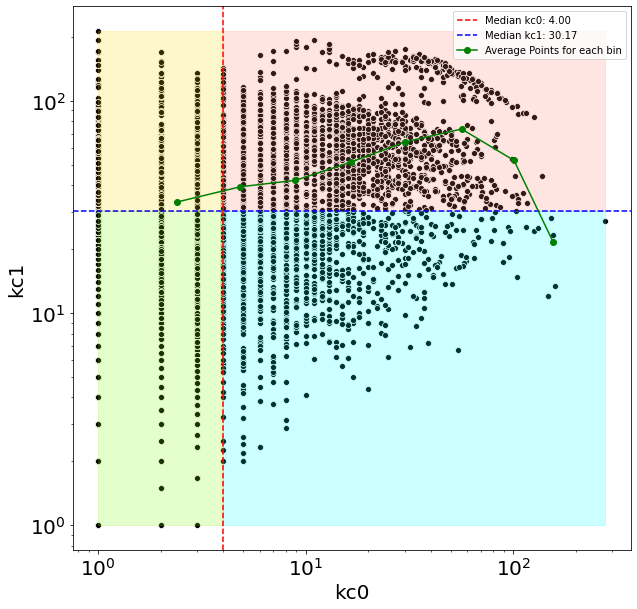

In [18]:
# Scatter plot for kc0-kc1 with log scale
plt.figure(figsize=(10, 10))
sns.scatterplot(x='kc0', y='kc1', data=kc_df, color='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('kc0', fontsize=20)
plt.ylabel('kc1', fontsize=20)
plt.tick_params(axis='both', labelsize=20)

# Add reference lines for median values for kc0 and kc1 respectively
median_kc0 = kc_df['kc0'].median()
median_kc1 = kc_df['kc1'].median()
plt.axvline(median_kc0, color='red', linestyle='--', label=f'Median kc0: {median_kc0:.2f}')
plt.axhline(median_kc1, color='blue', linestyle='--', label=f'Median kc1: {median_kc1:.2f}')

# Group by bins and calculate mean for each bin
bins = np.logspace(np.log10(kc_df['kc0'].min()), np.log10(kc_df['kc0'].max()), num=10)
kc_df['kc0_bins'] = pd.cut(kc_df['kc0'], bins=bins)
average_values = kc_df.groupby('kc0_bins').mean()

# Line plot connecting average points
plt.plot(average_values['kc0'], average_values['kc1'], marker='o', linestyle='-', color='green', label='Average Points for each bin')

# Color the quadrants
plt.fill_betweenx(y=[median_kc1, kc_df['kc1'].max()], x1=median_kc0, x2=kc_df['kc0'].max(), color='salmon', alpha=0.2)
plt.fill_betweenx(y=[kc_df['kc1'].min(), median_kc1], x1=median_kc0, x2=kc_df['kc0'].max(), color='cyan', alpha=0.2)
plt.fill_betweenx(y=[kc_df['kc1'].min(), median_kc1], x1=kc_df['kc0'].min(), x2=median_kc0, color='lawngreen', alpha=0.2)
plt.fill_betweenx(y=[median_kc1, kc_df['kc1'].max()], x1=kc_df['kc0'].min(), x2=median_kc0, color='gold', alpha=0.2)
plt.legend()
plt.show()

In [22]:
# create dataframe by extract course_name, coverage, label and degree of each node
course_impact = []
for node in G.nodes():
    node_data = {
        'Node': G.nodes[node]['name'],
        'coverage': G.nodes[node]['course_coverage'],
        'label':G.nodes[node]['label'],
        'degree': G.degree(node)}  
    course_impact.append(node_data)

# Create a Pandas DataFrame
course_impact_df = pd.DataFrame(course_impact)
# Calculate 'course_impact'
course_impact_df['course_impact'] = course_impact_df['coverage'] / course_impact_df['degree']
course_impact_df

,Node,coverage,label,degree,course_impact
0,Certificate in Athlete Life Coaching,1.0,Sports,28,0.035714
1,Developing People,23.0,Leadership & People Management,434,0.052995
2,Coaching for Peak Performance,7.0,Wholesale and Retail Trade,193,0.036269
3,Coach for Service Performance (Service Coachin...,4.0,Service Excellence,33,0.121212
4,Career Coaching Level 5: Develop and Implement...,3.0,"Human Resource Management, Employment and Recr...",74,0.040541
...,...,...,...,...,...
6183,"Chemistry, Manufacturing and Controls (Synchro...",1.0,Healthcare,1,1.000000
6184,International and Comparative Insolvency Law i...,1.0,Legal,1,1.000000
6185,Corporate Insolvency Law,2.0,Business Management,1,2.000000
6186,Working with Families (In-Service Staff),1.0,Healthcare,1,1.000000


In [23]:
#to compare impact and ubiquity, merge the two dataframes
merged_df = pd.merge(kc_df, course_impact_df, on='Node', how='left')

# Drop duplicate columns (if needed)
merged_df = merged_df.dropna().reset_index()
merged_df = merged_df.drop(columns=['index','kc0_bins'])
merged_df

,Node,kc0,kc1,kc2,coverage,label,degree,course_impact
0,Certificate Course in 2nd Grade Computer Aided...,8.0,30.875000,7.374637,8.0,Engineering,78.0,0.102564
1,Certificate Course in 2nd Grade Engineering Ma...,3.0,4.333333,2.133333,3.0,Engineering,7.0,0.428571
2,Certificate Course in 1st Grade Engineering Ma...,2.0,5.500000,2.200000,2.0,Engineering,6.0,0.333333
3,Joint ITE-UPEC Certificate in Pre-Hospital Eme...,10.0,30.100000,11.625168,10.0,Healthcare,130.0,0.076923
4,FIRE SAFETY MANAGER COURSE,3.0,35.000000,23.412787,3.0,Workplace Safety and Health,71.0,0.042254
...,...,...,...,...,...,...,...,...
4782,Good Dispensing Practice (part of PDC2 of Adva...,5.0,9.400000,9.201818,5.0,Pharmaceutical and Biotechnology,11.0,0.454545
4783,Drug Information (part of PDC2 of Advanced Dip...,4.0,10.750000,9.627273,4.0,Pharmaceutical and Biotechnology,11.0,0.363636
4784,Audit Management I,10.0,12.500000,18.679067,10.0,Healthcare,52.0,0.192308
4785,"""Think Out Of The Box"" (Synchronous e-Learning)",6.0,44.500000,25.000518,6.0,Productivity and Innovation,134.0,0.044776


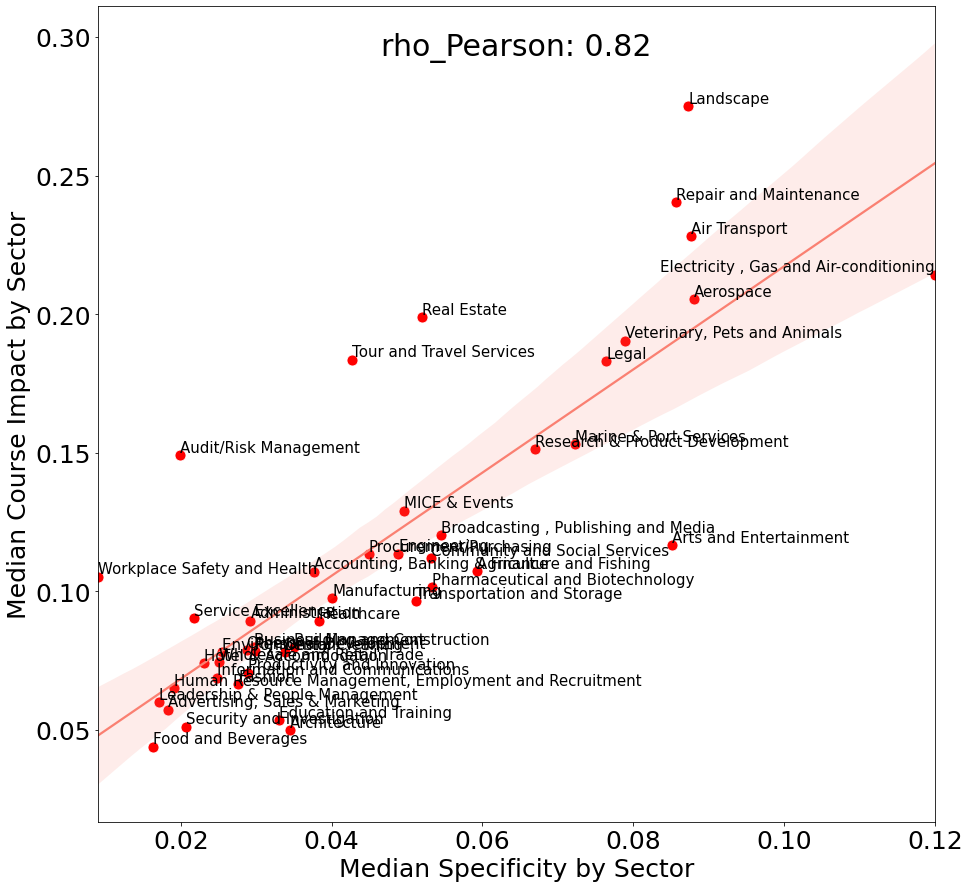

In [55]:
sector_df = merged_df.groupby('label')[['kc0','kc1','kc2','course_impact']].median().reset_index()

# Count the number of courses in each group
course_counts = merged_df['label'].value_counts().reset_index()
course_counts.columns = ['label', 'course_count']

# Merge the median_kc DataFrame with course_counts
sector_df = pd.merge(sector_df, course_counts, on='label')

# Filter out groups with counts under 5
sector_df_filtered = sector_df[sector_df['course_count'] >= 5]
sector_df_filtered = sector_df_filtered.drop('course_count', axis=1)

# Calculate the inverse of kc1
sector_df_filtered['specificity'] = 1 / sector_df_filtered['kc1']

# Create a scatter plot
plt.figure(figsize=(15, 15))
sns.scatterplot(x='specificity', y='course_impact', data=sector_df_filtered, color='red', s=120)

# Draw a fitted line (regression line)
sns.regplot(x='specificity', y='course_impact', data=sector_df_filtered, scatter=False, color='salmon')

# Calculate the correlation coefficient'b
correlation_coefficient_inverse_kc1 = sector_df_filtered['specificity'].corr(sector_df_filtered['course_impact'])

# Annotate each point with its corresponding label
for label, x, y in zip(sector_df_filtered['label'], sector_df_filtered['specificity'], sector_df_filtered['course_impact']):
    ha_value = 'left' if label != 'Electricity , Gas and Air-conditioning' else 'right'
    plt.text(x, y, label, fontsize=15, ha=ha_value,va='bottom', color='black')

    
# Annotate the plot with the correlation coefficient
plt.annotate(f'rho_Pearson: {correlation_coefficient_inverse_kc1:.2f}',
             xy=(0.5, 0.95), xycoords='axes fraction',
             ha='center', va='center', fontsize=30, color='black')

# Set x-axis limits
plt.xlabel('Median Specificity by Sector', fontsize=25)
plt.ylabel('Median Course Impact by Sector', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.savefig('Specificity_CourseImpact_scatter.png', bbox_inches='tight', dpi=300)

plt.show()

In [25]:
def process_transferability_data(csv_file, skill_df, B, G, transferability_type):
    # Read CSV file
    transferability_data = pd.read_csv(csv_file)
    transferability_data = transferability_data.rename(columns={'Title of Priority Skill': 'TSC_CCS Title', 'Description of Priority Skill': 'TSC_CCS Description'})
    df_skill_original = pd.read_csv(skill_df)
    
    def percentage_to_float(percentage_str):
        return float(percentage_str.strip('%'))

    # Apply the function to the DataFrame
    transferability_data['Demand Growth'] = transferability_data['Demand Growth'].apply(percentage_to_float)
    transferability_data['label'] = transferability_type

    # Merge dataframes and drop NaN values
    skill_data = pd.merge(transferability_data, df_skill_original, on=['TSC_CCS Title', 'TSC_CCS Description'], how='left')
    skill_data = skill_data.dropna()
    skill_data = skill_data[['TSC_CCS Code', 'label', 'TSC_CCS Title', 'TSC_CCS Description', 'Transferability']]

    # Convert dataframe to dictionary
    skills_data = skill_data.set_index('TSC_CCS Code')['Transferability'].to_dict()

    # Extract skill_names from skills_data
    skill_names = list(skills_data.keys())

    # Assign values from skills_data to nodes in the graph
    for skill_name in skill_names:
        value = skills_data[skill_name]
        B.nodes[skill_name][f'{transferability_type}_transferability'] = value

    # Create a dictionary to store the total node sizes for each course node
    course_sizes = {}

    # Iterate through the course nodes
    for course_node in B.nodes:
        total_size = 0

        # Get the skill node neighbors of the course node
        skill_neighbors = [neighbor_node for neighbor_node in B.neighbors(course_node) if B.nodes[neighbor_node]['bipartite'] == 1]

        for skill_node in skill_neighbors:
            if f'{transferability_type}_transferability' in B.nodes[skill_node]:
                # Correctly accumulate the transferability_value
                transferability_value = B.nodes[skill_node][f'{transferability_type}_transferability']
                total_size += transferability_value

        # Store the total size for the course node
        course_sizes[course_node] = total_size

    # Assign '{transferability_type}_transferability' attribute to the nodes in G
    for course_node, transferability_value in course_sizes.items():
        # Check if the course node is in G based on the 'name' attribute
        nodes_with_name = [node for node in G.nodes if 'name' in G.nodes[node] and G.nodes[node]['name'] == course_node]
        if nodes_with_name:
            G.nodes[nodes_with_name[0]][f'{transferability_type}_transferability'] = transferability_value

In [26]:
process_transferability_data('Green Economy.csv', 'df_skill_original.csv', B, G, 'green')
process_transferability_data('Digital Economy.csv', 'df_skill_original.csv', B, G, 'digital')
process_transferability_data('Care Economy.csv', 'df_skill_original.csv', B, G, 'care')
process_transferability_data('I4.0 Economy.csv', 'df_skill_original.csv', B, G, 'i40')

In [ ]:
##직업/스킬 카테고리에 대한 섀넌 엔트로피 계산

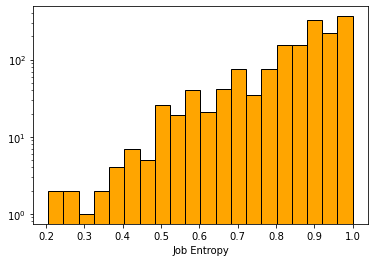

In [29]:
# Assign values from skills_data to partition 1 nodes
job_data = df_job.set_index('id')['sector_label'].to_dict()

for skill_name in skill_names:
    if skill_name in job_data:
        value =  job_data[skill_name]
        B.nodes[skill_name]['job_sector'] = value  # Add 'value' attribute to the node
        
# Calculate the overall unique job sectors
unique_job_sectors = set()
for skill_node in B.nodes(data=True):
    if skill_node[1]['bipartite'] == 1 and 'job_sector' in skill_node[1]:
        unique_job_sectors.add(skill_node[1]['job_sector'])

conditional_probs = {}

# Iterate through course nodes
for course_node in B.nodes(data=True):
    if course_node[1]['bipartite'] == 0:  # Check if it's a course node
        course_name = course_node[0]
        skill_neighbors = list(B.neighbors(course_name))

        if not skill_neighbors:
            continue  # Skip course nodes with no skill neighbors

        # Count the occurrence of each job sector in the neighbors
        job_sector_counts = {}
        for skill_neighbor in skill_neighbors:
            if 'job_sector' in B.nodes[skill_neighbor]:
                job_sector = B.nodes[skill_neighbor]['job_sector']
                job_sector_counts[job_sector] = job_sector_counts.get(job_sector, 0) + 1

        # Calculate conditional probabilities
        conditional_probs[course_name] = {job_sector: count / len(skill_neighbors) for job_sector, count in job_sector_counts.items()}


# Filter out course nodes with empty conditional_probs
conditional_probs = {course_name: probs for course_name, probs in conditional_probs.items() if probs}

# Calculate entropy for each course node using scipy.stats.entropy
job_entropy_values = {}
for course_name, conditional_probabilities in conditional_probs.items():
    prob_values = np.array(list(conditional_probabilities.values()))

    num_groups = len(conditional_probs[course_name])

    if num_groups >= 2:
       entropy_value = entropy(prob_values, base=num_groups)
 #   log_scaled_entropy_value = entropy_value / np.log(num_groups)
    else:
       entropy_value = None  # Assign None for courses with no skill categories

    #if num_groups > 0:
    #    entropy_value = entropy(prob_values)
        #log_scaled_entropy_value = entropy_value / np.log(num_groups) if num_groups > 1 else 0
    #else:
    #    entropy_value = None
    #    #log_scaled_entropy_value = None
    
    job_entropy_values[course_name] = entropy_value #log_scaled_entropy_value

# Create a histogram to visualize the distribution of entropy values
entropy_list = [value for value in job_entropy_values.values() if value is not None]

plt.hist(entropy_list, bins=20, color='orange', edgecolor='black')
plt.xlabel('Job Entropy')
plt.yscale('log')
plt.show()

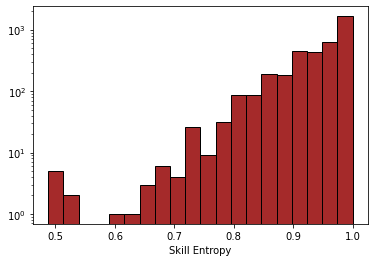

In [30]:
# Assign values from skills_data to partition 1 nodes
skill_data = df_skill.set_index('id')['skill_label'].to_dict()

for skill_name in skill_names:
    if skill_name in skill_data:
        value =  skill_data[skill_name]
        B.nodes[skill_name]['skill_category'] = value  # Add 'value' attribute to the node
        
# Calculate the overall unique job sectors
unique_skill_categories = set()
for skill_node in B.nodes(data=True):
    if skill_node[1]['bipartite'] == 1 and 'skill_category' in skill_node[1]:
        unique_skill_categories.add(skill_node[1]['skill_category'])

# Create a dictionary to store conditional probabilities of job sectors given skill neighbors
conditional_probs = {}

# Iterate through course nodes
for course_node in B.nodes(data=True):
    if course_node[1]['bipartite'] == 0:  # Check if it's a course node
        course_name = course_node[0]
        skill_neighbors = list(B.neighbors(course_name))

        if not skill_neighbors:
            continue  # Skip course nodes with no skill neighbors

        # Count the occurrence of each job sector in the neighbors
        skill_category_counts = {}
        for skill_neighbor in skill_neighbors:
            if 'skill_category' in B.nodes[skill_neighbor]:
                skill_category = B.nodes[skill_neighbor]['skill_category']
                skill_category_counts[skill_category] = skill_category_counts.get(skill_category, 0) + 1

        # Calculate conditional probabilities
        conditional_probs[course_name] = {skill_category: count / len(skill_neighbors) for skill_category, count in skill_category_counts.items()}

# Calculate entropy for each course node using scipy.stats.entropy
skill_entropy_values = {}
for course_name, conditional_probabilities in conditional_probs.items():
    prob_values = np.array(list(conditional_probabilities.values()))

    num_groups = len(conditional_probs[course_name])

    if num_groups >= 2:
       entropy_value = entropy(prob_values, base=num_groups)
    else:
       entropy_value = None  # Assign None for courses with no skill categories

    skill_entropy_values[course_name] = entropy_value

    # Create a histogram to visualize the distribution of entropy values
entropy_list = [value for value in skill_entropy_values.values() if value is not None]
plt.hist(entropy_list, bins=20, color='brown', edgecolor='black')
plt.xlabel('Skill Entropy')
plt.yscale('log')
plt.show()

In [ ]:
##Course Impact 계산 및 회귀

In [31]:
# Assuming G is your network and entropy_values is the dictionary of entropy values
for node in G.nodes(data=True):
    node_name = node[1]['name']  # Assuming 'name' is the attribute to match
    if node_name in skill_entropy_values:
        entropy_value = skill_entropy_values[node_name]
        G.nodes[node[0]]['skill_entropy_value'] = entropy_value

In [32]:
# Assuming G is your network and entropy_values is the dictionary of entropy values
for node in G.nodes(data=True):
    node_name = node[1]['name']  # Assuming 'name' is the attribute to match
    if node_name in job_entropy_values:
        entropy_value = job_entropy_values[node_name]
        G.nodes[node[0]]['job_entropy_value'] = entropy_value

In [36]:
# Your existing code to create the 'node_data_list'
linear_df_list = []
for node in G.nodes():
    linear_df_data = {
        'course_name': G.nodes[node]['name'],
        'coverage': G.nodes[node]['course_coverage'],
        'green_transferability': G.nodes[node]['green_transferability'],
        'digital_transferability': G.nodes[node]['digital_transferability'],
        'care_transferability': G.nodes[node]['care_transferability'],
        'i40_transferability': G.nodes[node]['i40_transferability'],
        'label':G.nodes[node]['label'],
        'skill_diversity': G.nodes[node].get('skill_entropy_value', None), 
        'job_diversity': G.nodes[node].get('job_entropy_value', None),
        'degree': G.degree(node)}  # Add the 'degree' attribute
    linear_df_list.append(linear_df_data)

# Create a Pandas DataFrame
linear_df = pd.DataFrame(linear_df_list)
linear_df['course_impact'] = linear_df['coverage'] / linear_df['degree']
linear_df

,course_name,coverage,green_transferability,digital_transferability,care_transferability,i40_transferability,label,skill_diversity,job_diversity,degree,course_impact
0,Certificate in Athlete Life Coaching,1.0,0,0,433,0,Sports,NaN,NaN,28,0.035714
1,Developing People,23.0,0,0,2067,0,Leadership & People Management,0.953884,NaN,434,0.052995
2,Coaching for Peak Performance,7.0,0,0,1380,0,Wholesale and Retail Trade,1.000000,NaN,193,0.036269
3,Coach for Service Performance (Service Coachin...,4.0,0,0,438,0,Service Excellence,1.000000,NaN,33,0.121212
4,Career Coaching Level 5: Develop and Implement...,3.0,0,0,1042,0,"Human Resource Management, Employment and Recr...",0.918296,NaN,74,0.040541
...,...,...,...,...,...,...,...,...,...,...,...
6183,"Chemistry, Manufacturing and Controls (Synchro...",1.0,0,0,0,0,Healthcare,NaN,NaN,1,1.000000
6184,International and Comparative Insolvency Law i...,1.0,0,0,0,0,Legal,NaN,NaN,1,1.000000
6185,Corporate Insolvency Law,2.0,0,0,0,0,Business Management,NaN,NaN,1,2.000000
6186,Working with Families (In-Service Staff),1.0,0,0,0,0,Healthcare,NaN,NaN,1,1.000000


In [37]:
linear_df.isnull().sum()

course_name                   0
coverage                      0
green_transferability         0
digital_transferability       0
care_transferability          0
i40_transferability           0
label                         0
skill_diversity            2394
job_diversity              4601
degree                        0
course_impact                 0
dtype: int64

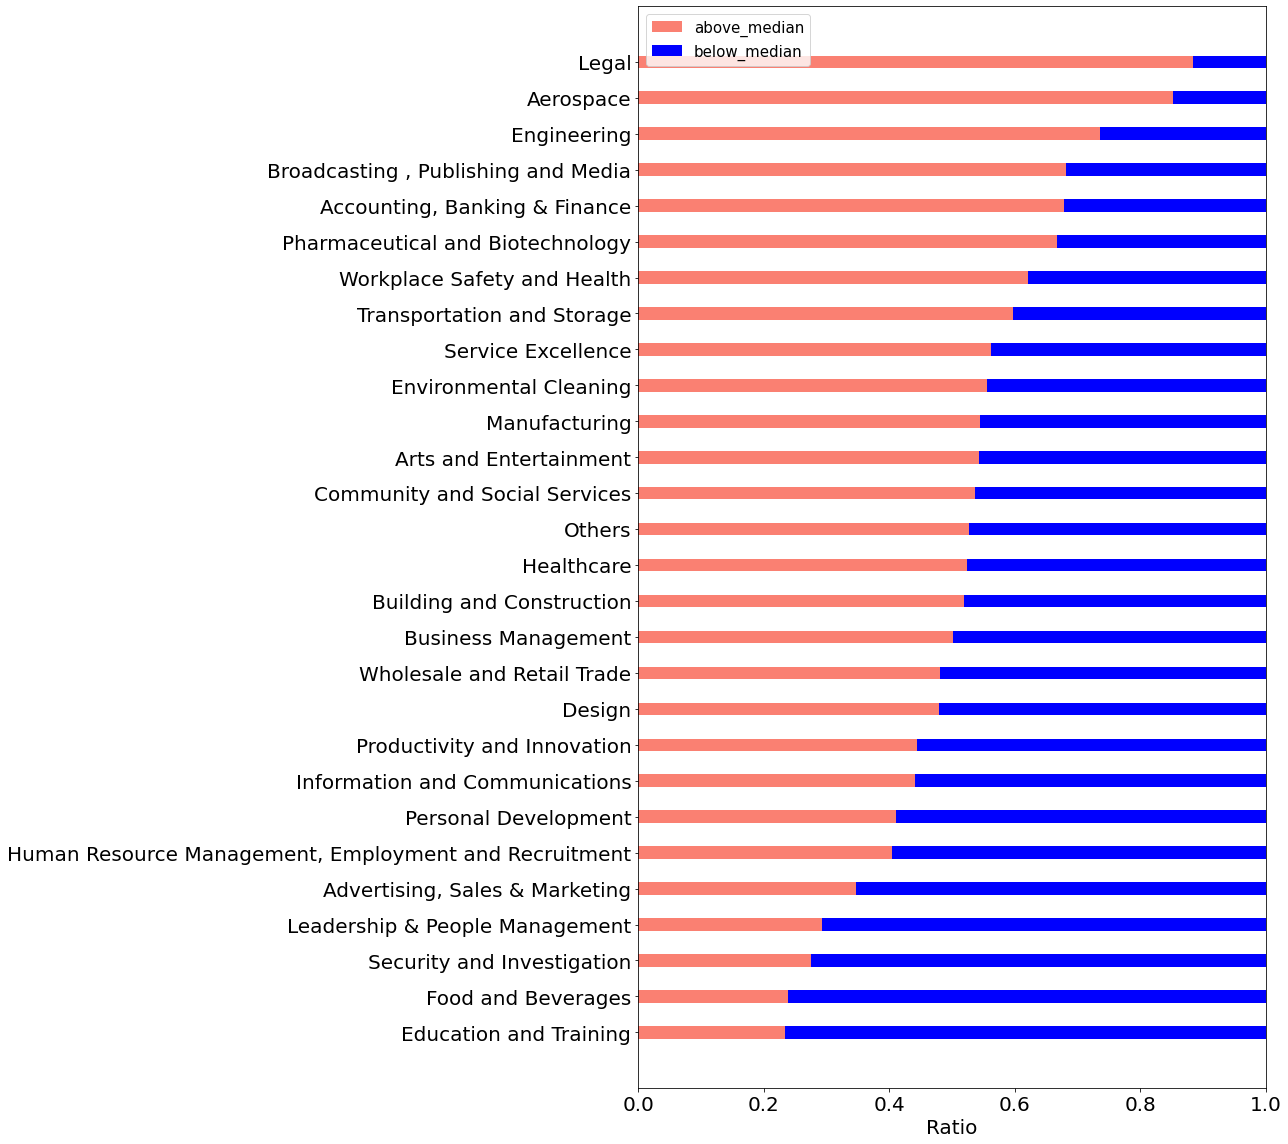

In [39]:
# Extract 'course_name' for rows where 'new_index' is greater than 2.0
median_course_impact = linear_df['course_impact'].median()
above_median_courses = linear_df.loc[linear_df['course_impact'] >= median_course_impact, 'label']
below_median_courses = linear_df.loc[linear_df['course_impact'] < median_course_impact, 'label']

above_median = above_median_courses.value_counts()
below_median = below_median_courses.value_counts()

# Combine the course names from both counts
all_courses = list(set(above_median.index).union(below_median.index))

# Calculate the total count for each course name by combining count_courses_1 and count_courses_2
total_counts = [above_median.get(course, 0) + below_median.get(course, 0) for course in all_courses]

# Filter out courses with total_counts less than 20
filtered_courses = [course for course, count in zip(all_courses, total_counts) if count >= 50]

# Calculate the ratios of count_courses_1 and count_courses_2 to total_counts for each course name
ratios_1 = [above_median.get(course, 0) / total_counts[i] for i, course in enumerate(all_courses)]
ratios_2 = [below_median.get(course, 0) / total_counts[i] for i, course in enumerate(all_courses)]

# Filter ratios based on filtered courses
ratios_1 = [ratio for course, ratio in zip(all_courses, ratios_1) if course in filtered_courses]
ratios_2 = [ratio for course, ratio in zip(all_courses, ratios_2) if course in filtered_courses]

# Sort the bars based on ratios_1 (blue color)
sorted_indices = np.argsort(ratios_1)
filtered_courses = [filtered_courses[i] for i in sorted_indices]
ratios_1 = [ratios_1[i] for i in sorted_indices]
ratios_2 = [ratios_2[i] for i in sorted_indices]

# Create a figure
fig, ax = plt.subplots(figsize=(18, 16))

# Calculate the position for each course name
y = np.arange(len(filtered_courses))

# Bar width for each group of bars
bar_width = 0.35

# Create bars for count_courses_1 ratios
ax.barh(y, ratios_1, bar_width, label='above_median', color='salmon')

# Create bars for count_courses_2 ratios
ax.barh(y, ratios_2, bar_width, label='below_median', color='blue', left=ratios_1)  # Align bars for comparison

# Set y-axis labels
ax.set_yticks(y)
ax.set_yticklabels(filtered_courses, fontsize=20)
ax.set_xlim(0, 1)  # Set the x-axis limit to 0-1 for ratios
ax.tick_params(axis='x', labelsize=20)
ax.set_xlabel("Ratio",fontsize=20)
ax.legend(fontsize=15)

# Adjust layout and display the chart
plt.tight_layout()
plt.savefig('course_impact_by_sector.png',dpi=300)

plt.show()

In [40]:
linear_df.dropna(subset=['job_diversity', 'skill_diversity'], inplace=True)

scaler = MinMaxScaler()
columns_to_normalize = ['green_transferability', 'digital_transferability', 'care_transferability', 'i40_transferability']
linear_df[columns_to_normalize] = scaler.fit_transform(linear_df[columns_to_normalize])

In [41]:
# Fit the linear regression model with dummy variables for 'label'
reg = sm.OLS.from_formula('course_impact ~ green_transferability+digital_transferability+care_transferability+i40_transferability+job_diversity+skill_diversity+C(label)+1', linear_df).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          course_impact   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     14.91
Date:                Wed, 20 Dec 2023   Prob (F-statistic):           1.66e-97
Time:                        16:40:10   Log-Likelihood:                 1725.1
No. Observations:                1402   AIC:                            -3346.
Df Residuals:                    1350   BIC:                            -3073.
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                             0.5359      0.036     15.057      0.000       0.466       0.606
C(label)[T.Administration]                                           -0.0112      0.029     -0.388      0.698      -0.068       0.046
C(label)[T.Advertising, Sales & Marketing]                           -0.0367      0.014     -2.718      0.007      -0.063      -0.010
C(label)[T.Aerospace]                                                 0.1194      0.027      4.343      0.000       0.065       0.173
C(label)[T.Agriculture and Fishing]                                   0.2007      0.052      3.871      0.000       0.099       0.302
C(label)[T.Arts and Entertainment]                                   -0.0466      0.052     -0.897      0.370      -0.148       0.055
C(label)[T.Audit/Risk Management]                                    -0.0339      0.025     -1.362      0.174      -0.083       0.015
C(label)[T.Broadcasting , Publishing and Media]                       0.0686      0.014      4.848      0.000       0.041       0.096
C(label)[T.Building and Construction]                                -0.0160      0.018     -0.911      0.363      -0.050       0.018
C(label)[T.Business Management]                                      -0.0253      0.011     -2.234      0.026      -0.047      -0.003
C(label)[T.Community and Social Services]                            -0.0161      0.019     -0.839      0.402      -0.054       0.022
C(label)[T.Design]                                                   -0.0264      0.020     -1.320      0.187      -0.066       0.013
C(label)[T.Domestic Cleaning]                                        -0.0768      0.073     -1.055      0.292      -0.220       0.066
C(label)[T.Education and Training]                                   -0.0450      0.014     -3.188      0.001      -0.073      -0.017
C(label)[T.Electricity , Gas and Air-conditioning]                   -0.0287      0.073     -0.395      0.693      -0.171       0.114
C(label)[T.Engineering]                                               0.0101      0.013      0.769      0.442      -0.016       0.036
C(label)[T.Environmental Cleaning]                                   -0.0235      0.015     -1.550      0.121      -0.053       0.006
C(label)[T.Fashion]                                                  -0.0347      0.037     -0.929      0.353      -0.108       0.039
C(label)[T.Food and Beverages]                                       -0.0562      0.012     -4.506      0.000      -0.081      -0.032
C(label)[T.Healthcare]                                               -0.0198      0.024     -0.832      0.406      -0.066       0.027
C

In [ ]:
# Assign values from skills_data to partition 1 nodes
course_data = filtered_course_df.set_index('title')['label'].to_dict()

for course_name in course_names:
    if course_name in course_data:
        value =  course_data[course_name]
        B.nodes[course_name]['course_label'] = value  # Add 'value' attribute to the node

# Iterate through skill nodes
for skill_node in B.nodes(data=True):
    if skill_node[1]['bipartite'] == 1 and 'job_sector' in skill_node[1]:  # Check if it's a skill node with 'job_sector'
        skill_name = skill_node[0]
        course_neighbors = list(B.neighbors(skill_name))

        # Print the number of course node neighbors for each skill node with 'job_sector'
        print(f"Skill: {skill_name}, Number of Course Node Neighbors: {len(course_neighbors)}")

In [42]:
job_data = df_job.set_index('id')['sector_label'].to_dict()

for skill_name in skill_names:
    if skill_name in job_data:
        value = job_data[skill_name]
        B.nodes[skill_name]['sector_label'] = value  # Use 'industry' consistently

# Iterate through skill nodes
total_neighbors = 0
total_nodes = 0
job_counts = {}

for skill_node in B.nodes(data=True):
    if skill_node[1]['bipartite'] == 1 and 'sector_label' in skill_node[1]:
        skill_name = skill_node[0]
        course_neighbors = list(B.neighbors(skill_name))

        job = skill_node[1]['sector_label']

        if job not in job_counts:
            job_counts[job] = []
        job_counts[job].append(len(course_neighbors))

        total_neighbors += len(course_neighbors)
        total_nodes += 1

# Calculate average number of neighbors
average_neighbors = total_neighbors / total_nodes if total_nodes > 0 else 0

print("Average number of neighbors for skill nodes with 'job_label':", average_neighbors)

Average number of neighbors for skill nodes with 'job_label': 16.290521978021978


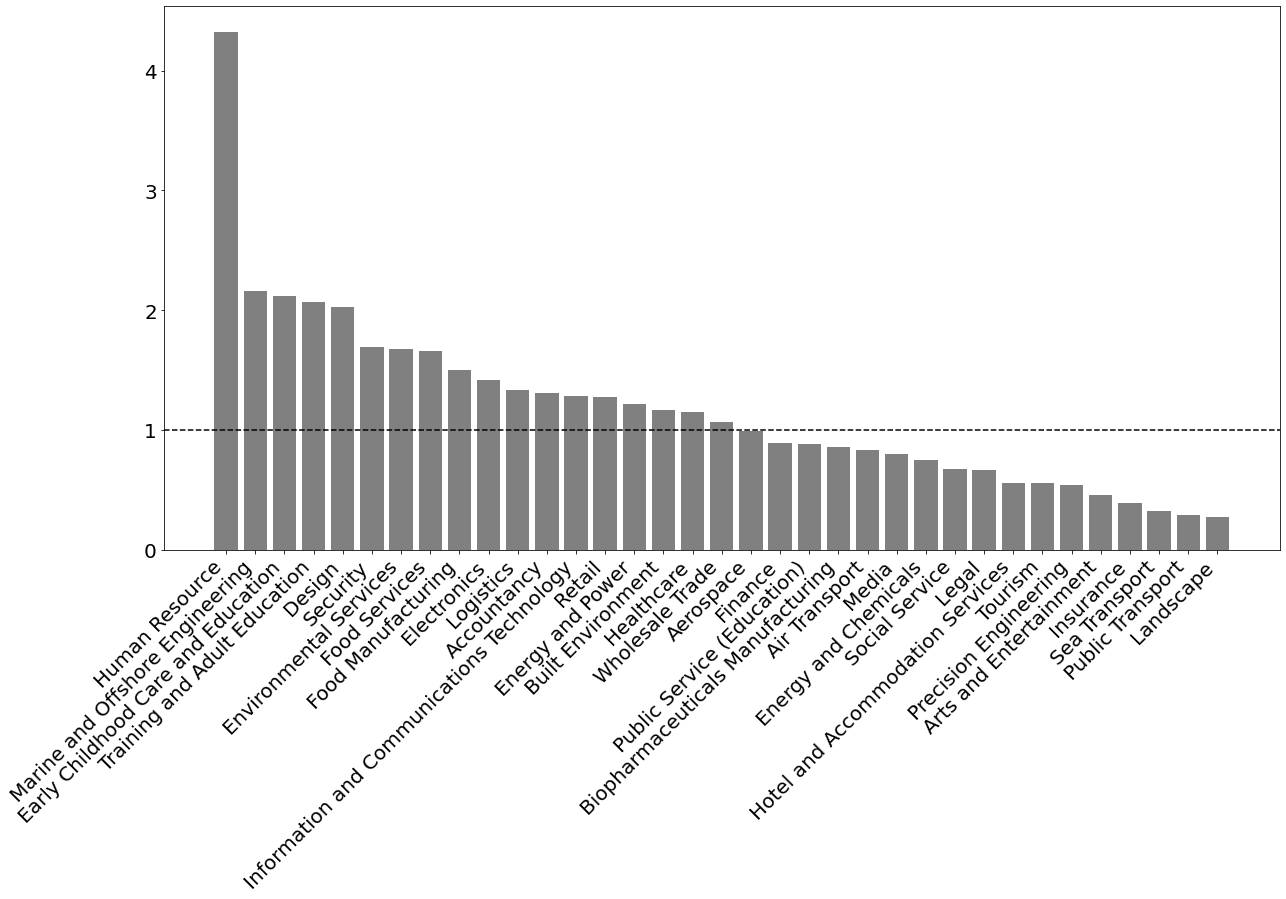

In [65]:
# Dictionary to store the counts of course node neighbors for each industry
course_counts = {}

# Iterate through skill nodes
for skill_node in B.nodes(data=True):
    if skill_node[1]['bipartite'] == 1 and 'sector_label' in skill_node[1]:
        skill_name = skill_node[0]
        course_neighbors = list(B.neighbors(skill_name))

        course = skill_node[1]['sector_label']  # Use 'industry' consistently

        if course not in course_counts:
            course_counts[course] = []
        course_counts[course].append(len(course_neighbors))
        
# Create a DataFrame from the results
data = {'sector_label': [], 'avg_course_relevant': []}
for job_label, counts in course_counts.items():

    job_counts = len(counts)
    average_course_provided = sum(counts) / job_counts

    data['sector_label'].append(job_label)
    data['avg_course_relevant'].append(average_course_provided)

result_df = pd.DataFrame(data)
result_df['inequality_index'] = result_df['avg_course_relevant'] / average_neighbors
# Sort the DataFrame by avg_course_relevant in descending order
result_df = result_df.sort_values(by='inequality_index', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(20, 10))
plt.bar(result_df['sector_label'], result_df['inequality_index'],color='grey')
plt.xticks(rotation=45, ha='right',fontsize=20)
plt.yticks(fontsize=20)
plt.axhline(y=1, color='black', linestyle='--')
plt.show()

In [48]:
df_skill_original = pd.read_csv('df_skill_original.csv')

df_skill_tmp = df_skill_original.copy()
df_skill_tmp['Proficiency Level'] = df_skill_tmp['Proficiency Level'].astype(str)
df_skill_tmp['Proficiency Level'] = df_skill_tmp['Proficiency Level'].replace({'1': 'low', '2': 'low', '3': 'low', '4': 'high', '5': 'high', '6': 'high','Advanced':'high'})

value_counts = df_skill_tmp['Proficiency Level'].value_counts()
# counts for 'low profiency skill' and 'high proficiency skill'
low = value_counts.get('low', 0)
high = value_counts.get('high', 0)

In [49]:
# Assign values from industry_data to partition 1 nodes
proficiency_info = df_skill_tmp.set_index('TSC_CCS Code')['Proficiency Level'].to_dict()

for skill_name in skill_names:
    if skill_name in proficiency_info:
        value = proficiency_info[skill_name]
        B.nodes[skill_name]['tsc_proficiency'] = value  # Use 'industry' consistently

In [50]:
# Initialize dictionaries to store counts
count_low = {}
count_high = {}

# Iterate through course nodes
for course_node in B.nodes(data=True):
    if course_node[1]['bipartite'] == 0:  # Check if it's a course node
        course_name = course_node[0]
        skill_neighbors = list(B.neighbors(course_name))

        if not skill_neighbors:
            continue  # Skip course nodes with no skill neighbors

        # Initialize counts for the current course
        count_low[course_name] = 0
        count_high[course_name] = 0

        for skill_neighbor in skill_neighbors:
            if 'tsc_proficiency' in B.nodes[skill_neighbor]:
                tsc_proficiency_category = B.nodes[skill_neighbor].get('tsc_proficiency')

                # Update counts based on proficiency category
                if tsc_proficiency_category == 'low':
                    count_low[course_name] += 1
                elif tsc_proficiency_category == 'high':
                    count_high[course_name] += 1

# Check if both dictionaries are not empty before creating the DataFrame
if count_low and count_high:
    # Create a DataFrame from the counts
    proficiency_df = pd.DataFrame({
        'course_name': list(count_low.keys()),
        'low_count': list(count_low.values()),
        'high_count': list(count_high.values())
    })

    # Add 'course_label' attribute to the DataFrame
    proficiency_df['course_label'] = proficiency_df['course_name'].apply(lambda x: B.nodes[x]['label'])

    # Optionally, you can set the 'course_name' column as the index
    proficiency_df.set_index('course_name', inplace=True)

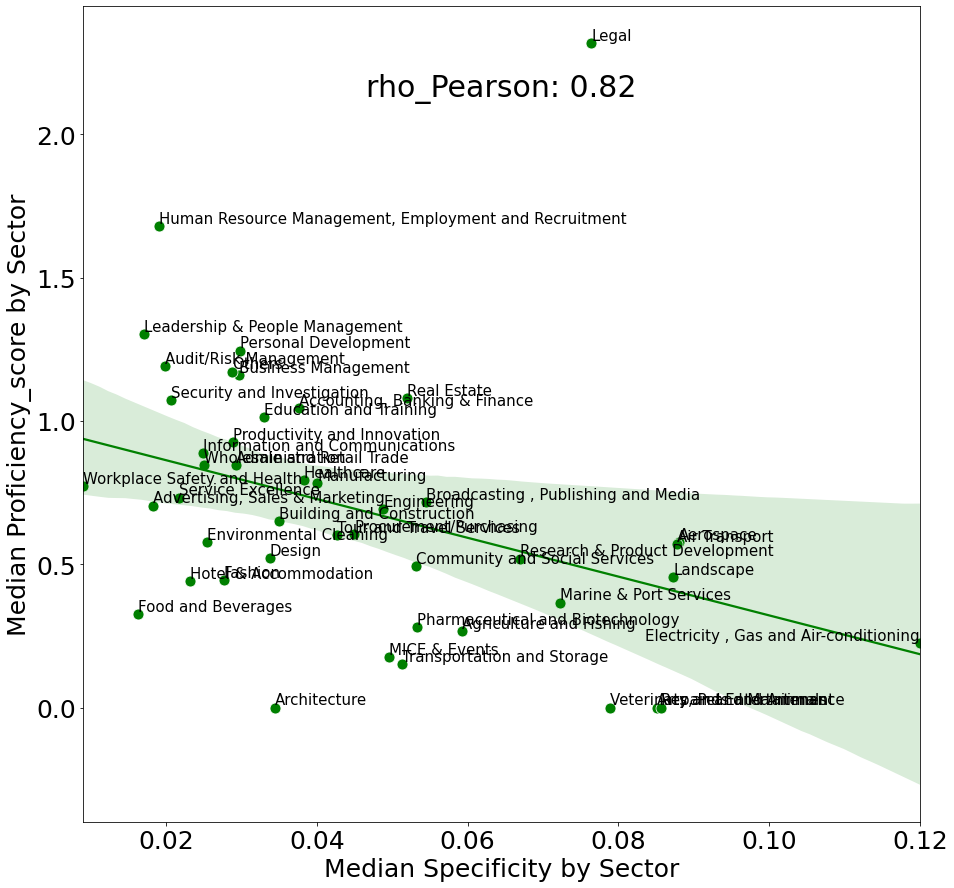

In [62]:
# Group by 'course_label' and sum the counts for each group
sector_proficiency = proficiency_df.groupby('course_label').agg({'low_count': 'sum', 'high_count': 'sum'}).reset_index()

# Add 'Proficiency_score' column
total_high_counts = high
total_low_counts = low
sector_proficiency['proficiency_score'] = sector_proficiency['high_count'] / (sector_proficiency['high_count'] + sector_proficiency['low_count'])
sector_proficiency['proficiency_score'] = sector_proficiency['proficiency_score'] / (total_high_counts / (total_high_counts + total_low_counts))
sector_proficiency = sector_proficiency.drop(columns=['low_count','high_count'])

merged_df_total = pd.merge(sector_df_filtered, sector_proficiency, left_on='label',right_on='course_label', how='left')
merged_df_total = merged_df_total.drop(columns=['course_label'])


correlation_coefficient = merged_df_total['specificity'].corr(merged_df_total['proficiency_score'])
# Annotate the plot with the correlation coefficient

# Create a scatter plot
plt.figure(figsize=(15, 15))

# Annotate each point with its corresponding label
for label, x, y in zip(merged_df_total['label'], merged_df_total['specificity'], merged_df_total['proficiency_score']):
    ha_value = 'left' if label != 'Electricity , Gas and Air-conditioning' else 'right'
    plt.text(x, y, label, fontsize=15, ha=ha_value,va='bottom', color='black')
    
    
# Annotate the plot with the correlation coefficient
plt.annotate(f'rho_Pearson: {correlation_coefficient_inverse_kc1:.2f}',
             xy=(0.5, 0.90), xycoords='axes fraction',
             ha='center', va='center', fontsize=30, color='black')

sns.scatterplot(x='specificity', y='proficiency_score', data=merged_df_total, color='green', s=120)
sns.regplot(x='specificity', y='proficiency_score', data=merged_df_total, scatter=False, color='green')

# Set x-axis limits
plt.xlabel('Median Specificity by Sector', fontsize=25)
plt.ylabel('Median Proficiency_score by Sector', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.show()